In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append('../../')
from noise2seg.models import Noise2Seg, Noise2SegConfig
import numpy as np
from csbdeep.utils import plot_history
from noise2seg.utils.misc_utils import combine_train_test_data, shuffle_train_data, augment_data
from noise2seg.utils.seg_utils import *
from noise2seg.utils.compute_precision_threshold import measure_precision
from keras.optimizers import Adam
from matplotlib import pyplot as plt
from scipy import ndimage
import tensorflow as tf
import keras.backend as K
import urllib
import os
import zipfile

Using TensorFlow backend.


In [8]:
def PSNR(gt, img):
    mse = np.mean(np.square(gt - img))
    return 20 * np.log10(np.max(gt)-np.min(gt)) - 10 * np.log10(mse)

In [2]:
trainval_data =  np.load('/home/prakash/Desktop/fileserver_Noise2Seg/data/DSB2018_n20/train/train_data.npz')
test_data =  np.load('/home/prakash/Desktop/fileserver_Noise2Seg/data/DSB2018_n20/test/test_data.npz', allow_pickle=True)
train_images = trainval_data['X_train'].astype(np.float32)
val_images = trainval_data['X_val'].astype(np.float32)
test_images = test_data['X_test']

train_masks = trainval_data['Y_train']
val_masks = trainval_data['Y_val']
test_masks = test_data['Y_test']

In [3]:
print("Shape of train_images: ", train_images.shape, ", Shape of train_masks: ", train_masks.shape)
print("Shape of val_images: ", val_images.shape, ", Shape of val_masks: ", val_masks.shape)
print("Shape of test_images: ", test_images.shape, ", Shape of test_masks: ", test_masks.shape)

Shape of train_images:  (3800, 128, 128) , Shape of train_masks:  (3800, 128, 128)
Shape of val_images:  (670, 128, 128) , Shape of val_masks:  (670, 128, 128)
Shape of test_images:  (50,) , Shape of test_masks:  (50,)


In [4]:
fraction = 100 # Fraction of annotated GT and raw image pairs to use during training. 
random_seed = 1 # Seed to shuffle training data (annotated GT and raw image pairs).


assert 0 <fraction<= 100, "Fraction should be between 0 and 100"

X_shuffled, Y_shuffled = shuffle_train_data(train_images, train_masks, random_seed = random_seed)
X_frac, Y_frac = zero_out_train_data(X_shuffled, Y_shuffled, fraction = fraction)
print("Training Data \n..................")
X, Y_train_masks = augment_data(X_frac, Y_frac)
print("\n")
print("Validation Data \n..................")
X_val, Y_val_masks = val_images, val_masks

Training Data 
..................
Raw image size after augmentation (30400, 128, 128)
Mask size after augmentation (30400, 128, 128)


Validation Data 
..................


In [5]:
X = X[...,np.newaxis]
Y = convert_to_oneHot(Y_train_masks)
X_val = X_val[...,np.newaxis]
Y_val = convert_to_oneHot(Y_val_masks)
print("Shape of train images: ", X.shape, ", Shape of train masks: ", Y.shape)
print("Shape of validation images: ", X_val.shape, ", Shape of validation masks: ", Y_val.shape)

Shape of train images:  (30400, 128, 128, 1) , Shape of train masks:  (30400, 128, 128, 3)
Shape of validation images:  (670, 128, 128, 1) , Shape of validation masks:  (670, 128, 128, 3)


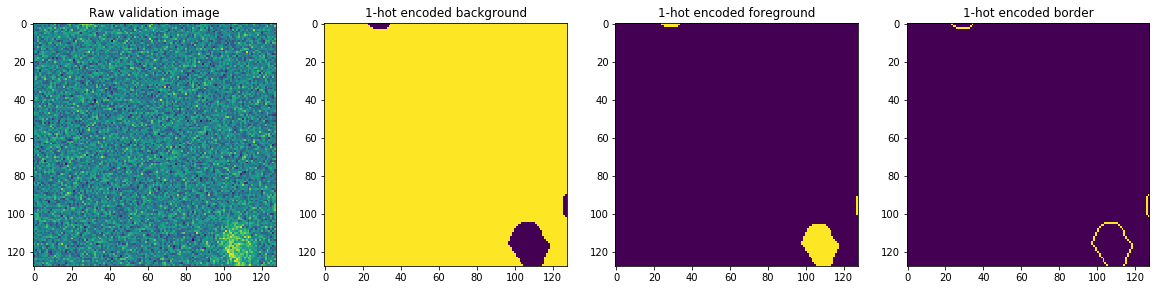

In [6]:
sl = 1
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.imshow(X[sl,...,0])
plt.title('Raw validation image')
plt.subplot(1,4,2)
plt.imshow(Y[sl,...,0], vmin=0, vmax=1)
plt.title('1-hot encoded background')
plt.subplot(1,4,3)
plt.imshow(Y[sl,...,1], vmin=0, vmax=1)
plt.title('1-hot encoded foreground')
plt.subplot(1,4,4)
plt.imshow(Y[sl,...,2], vmin=0, vmax=1)
plt.title('1-hot encoded border');

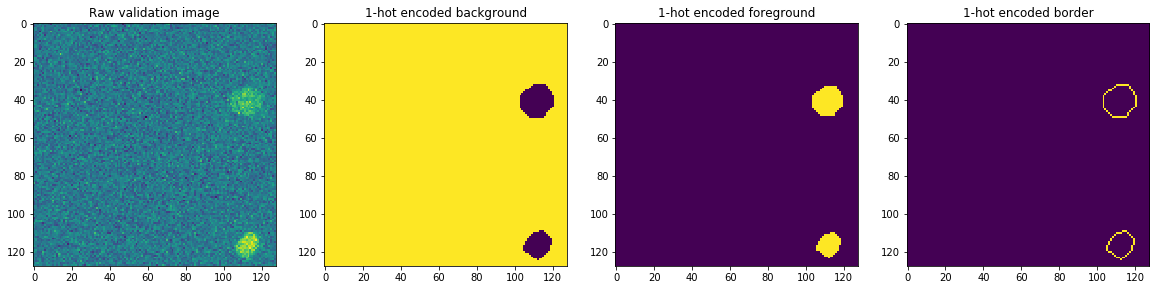

In [7]:
sl = -1
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.imshow(X[sl,...,0])
plt.title('Raw validation image')
plt.subplot(1,4,2)
plt.imshow(Y[sl,...,0], vmin=0, vmax=1)
plt.title('1-hot encoded background')
plt.subplot(1,4,3)
plt.imshow(Y[sl,...,1], vmin=0, vmax=1)
plt.title('1-hot encoded foreground')
plt.subplot(1,4,4)
plt.imshow(Y[sl,...,2], vmin=0, vmax=1)
plt.title('1-hot encoded border');

In [9]:
exp_name = 'alpha0.3_dsb_n20'
runs= ['1', '2', '3', '4', '5']
fracs = ['0.25']
gt_data = '/home/prakash/Desktop/fileserver_Noise2Seg/data/DSB2018_n0/test/test_data.npz'

In [10]:
groundtruth_data_npz = np.load(gt_data, allow_pickle=True)

In [11]:
groundtruth_data = groundtruth_data_npz['X_test']

In [12]:
psnr_per_fraction = []

for fraction_num in fracs:
    psnr_per_run_per_fraction = []
    for run_idx in runs:
        
        print("Computing for fraction: ", fraction_num+ " in experiment: ", exp_name+'_run'+run_idx)
        basedir = '/home/prakash/Desktop/fileserver_Noise2Seg/experiments/'+exp_name+'_run'+run_idx+'/fraction_'+fraction_num+'/'
        model_name = exp_name +'_run'+run_idx+'_model'
        n2s_model = Noise2Seg(None, model_name, basedir)
        denoised_images = []
        for j in range(test_images.shape[0]):
            denoised_ = n2s_model.predict(test_images[j].astype(np.float32),'YX')[...,0]
            denoised_images.append(denoised_)
        jointly_denoised_data = np.array(denoised_images)
        
        psnrs = []
        for gt, img in zip(groundtruth_data, jointly_denoised_data):
            psnrs.append(PSNR(gt, img))

        psnrs = np.array(psnrs)
        print("PSNR:", np.round(np.mean(psnrs), 2))
        
        psnr_per_run_per_fraction.append(np.round(np.mean(psnrs), 2))
    psnr_per_fraction.append((fraction_num, np.mean(psnr_per_run_per_fraction)))

Computing for fraction:  0.25 in experiment:  alpha0.3_dsb_n20_run1
Loading network weights from 'weights_best.h5'.
PSNR: 34.98
Computing for fraction:  0.25 in experiment:  alpha0.3_dsb_n20_run2
Loading network weights from 'weights_best.h5'.
PSNR: 34.66
Computing for fraction:  0.25 in experiment:  alpha0.3_dsb_n20_run3
Loading network weights from 'weights_best.h5'.
PSNR: 35.29
Computing for fraction:  0.25 in experiment:  alpha0.3_dsb_n20_run4
Loading network weights from 'weights_best.h5'.
PSNR: 34.77
Computing for fraction:  0.25 in experiment:  alpha0.3_dsb_n20_run5
Loading network weights from 'weights_best.h5'.
PSNR: 35.04


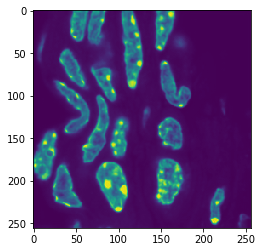

In [14]:
plt.imshow(jointly_denoised_data[0])

In [13]:
np.savetxt('/home/prakash/Desktop/fileserver_Noise2Seg/denoising_numbers/'+exp_name+'.txt', psnr_per_fraction, fmt='%s')